In [1]:
import os
import sys
import copy
import traceback
from typing import List, Dict
from datetime import datetime
from glob import glob
import json
import time
import argparse

from tqdm.auto import tqdm
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn, utils
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split

sys.path.append(r"C:\Users\confocal_microscope\Desktop\ZebraFish_AP_POS\modules") # add path to scan customized module
from logger import init_logger
from fileop import create_new_dir
from dl_utils import set_gpu, ImgDataset, caulculate_metrics, save_model, plot_training_trend

# print("="*100, "\n")

In [2]:
log = init_logger(r"Training")

constant path

In [3]:
ap_dataset_root = r"C:\Users\confocal_microscope\Desktop\{Test}_DataSet"
save_dir_root = r"C:\Users\confocal_microscope\Desktop\{Test}_Model_history"

args

In [4]:
dataset_name = r"{20230305_NEW_STRUCT}_Academia_Sinica_i409"
dataset_gen_method = "fish_dataset_horiz_cut_1l2_Mix_AP"
dataset_param_name = "DS_SURF3C_CRPS512_SF14_INT20_DRP100_RS2022"
cuda_idx = 1
label_in_filename = 0
train_ratio = 0.8
rand_seed = 2022
model_name = "vit_b_16"
pretrain_weights = "IMAGENET1K_V1"
epochs = 10
batch_size = 32
lr = 1e-5

debug_mode = False

# Create path var
save_dir_model = os.path.join(save_dir_root, model_name)
train_selected_dir = os.path.join(ap_dataset_root, dataset_name, dataset_gen_method, dataset_param_name, "train", "selected")

# Set GPU
device, device_name = set_gpu(cuda_idx)
log.info(f"Using '{device}', device_name = '{device_name}'")

| 2023-03-21 12:49:04,717 | Training | INFO | Using 'cuda', device_name = 'NVIDIA GeForce RTX 2080 Ti'


In [5]:
# Create save model directory
time_stamp = datetime.now().strftime('%Y%m%d_%H_%M_%S')
save_dir = os.path.join(save_dir_model, f"Training_{time_stamp}")
create_new_dir(save_dir)


## set random seed
np.random.seed(rand_seed)


# Scan classes to create 'class_map'
all_class_list = glob(os.path.normpath(f"{train_selected_dir}/*"))
all_class_list = [path.split(os.sep)[-1] for path in all_class_list]
all_class_list.sort()
class_map = {cls:i for i, cls in enumerate(all_class_list)}
log.info(class_map)


# Scan tiff
dataset_img_list = glob(os.path.normpath(f"{train_selected_dir}/*/*.tiff"))
log.info(f"total = {len(dataset_img_list)}")
## debug mode: only select first 200
if debug_mode:
    dataset_img_list = np.random.choice(dataset_img_list, size=200, replace=False)
    log.info(f"Debug mode, only select first {len(dataset_img_list)}")


# Split train, test dataset
train_img_list, valid_img_list = train_test_split(dataset_img_list, random_state=rand_seed, train_size=train_ratio)
## train
log.info(f"train_data ({len(train_img_list)})")
[log.info(f"{i}：img_path = {train_img_list[i]}") for i in range(5)]
## test
log.info(f"test_data ({len(valid_img_list)})")
[log.info(f"{i}：img_path = {valid_img_list[i]}") for i in range(5)]
## debug mode: read test
if debug_mode:
    reat_test = cv2.imread(train_img_list[-1])
    log.info(f"Read Test: {train_img_list[-1]}")
    cv2.imshow("Read Test", reat_test)
    cv2.waitKey(0)
## save 'training_amount'
training_amount = f"{{ dataset_{len(dataset_img_list)} }}_{{ train_{len(train_img_list)} }}_{{ valid_{len(valid_img_list)} }}"
f_writer = open(os.path.normpath(f"{save_dir}/{training_amount}"), mode="w")
f_writer.close()


# Create dataSets
train_set = ImgDataset(train_img_list, class_map=class_map, label_in_filename=label_in_filename)
valid_set = ImgDataset(valid_img_list, class_map=class_map, label_in_filename=label_in_filename)


# Initial dataLoader
train_dataloader = DataLoader(train_set, batch_size=batch_size, shuffle=True, pin_memory=True) # TODO:  Dataloader shuffle consistency
valid_dataloader = DataLoader(valid_set, batch_size=batch_size, shuffle=False, pin_memory=True)
log.info(f"total train batches: {len(train_dataloader)}")
log.info(f"total valid batches: {len(valid_dataloader)}")


# Create model
log.info(f"load model using 'torch.hub.load()', model_name:'{model_name}', pretrain_weights:'{pretrain_weights}'")
model = torch.hub.load('pytorch/vision', model_name, weights=pretrain_weights)
## modify model structure
model.heads.head = nn.Linear(in_features=768, out_features=len(class_map), bias=True)
model.to(device)
# print(model)


# Initial loss function and optimizer
loss_fn = nn.CrossEntropyLoss() # TODO:  add 'class_weight'
optimizer = torch.optim.AdamW(model.parameters(), lr=lr) # TODO:  use momentum, lr_scheduler


# Training
## training variables
train_logs = []
valid_logs = []
## progress bar
pbar_n_epoch = tqdm(total=epochs, desc=f"Epoch ")
pbar_n_train = tqdm(total=len(train_dataloader), desc="Train ")
pbar_n_valid = tqdm(total=len(valid_dataloader),desc="Valid ")
## best condition
best_log = {
    'epoch' : 0,
    'best_val_avg_loss': np.inf,
    'best_val_avg_f1': 0.0, # average_f1 = (macro_f1 + micro_f1) / 2
}
best_model_state_dict = copy.deepcopy(model.state_dict())
best_optimizer_state_dict = copy.deepcopy(optimizer.state_dict())
## start training
### TODO:  interrupt during training
start_time = time.time()
for epoch in range(epochs):
    
    # One-based iteration
    epoch_one_based = epoch+1
    
    # Update progress bar description
    pbar_n_epoch.desc = f"Epoch {epoch_one_based} "
    pbar_n_epoch.refresh()
    pbar_n_train.n = 0
    pbar_n_train.refresh()
    pbar_n_valid.n = 0
    pbar_n_valid.refresh()
    
    
    
    # Training
    ## reset variables
    epoch_train_log = { "Train": "", "epoch": epoch_one_based }
    pred_list = []
    gt_list = []
    accum_batch_loss = 0.0
    ## set to training mode
    model.train()
    for data in train_dataloader:
        x_train, y_train = data
        x_train, y_train = x_train.to(device), y_train.to(device) # move to GPU
        preds = model(x_train)
        loss_value = loss_fn(preds, y_train)
        _, pred_train = torch.max(preds, 1) # get the highest probability
        
        ## update mode_parameters by back_propagation
        loss_value.backward()
        optimizer.step()
        optimizer.zero_grad() # clean gradients after step
        
        ## extend 'pred_list', 'gt_list'
        pred_list.extend(pred_train.cpu().numpy().tolist())
        gt_list.extend(y_train.cpu().numpy().tolist())
        ## add current batch loss
        accum_batch_loss += loss_value.item()
        
        ## update 'pbar_n_train'
        pbar_n_train.update(1)
        pbar_n_train.refresh()
    
    caulculate_metrics(epoch_train_log, accum_batch_loss, len(train_dataloader),
                       gt_list, pred_list, class_map)
    # print(json.dumps(epoch_train_log, indent=4))
    train_logs.append(epoch_train_log)
    ## update postfix of 'pbar_n_train'
    pbar_n_train.postfix = " {} Loss:{:.4f}, Avg_f1: {:.4f} {} ".format("{", epoch_train_log["avg_loss"],
                                                                        epoch_train_log["average_f1"], "}")
    pbar_n_train.refresh()
    
    
    
    # Validating
    ## reset variables
    epoch_valid_log = { "Valid": "", "epoch": epoch_one_based }
    pred_list = []
    gt_list = []
    accum_batch_loss = 0.0
    ## set to evaluation mode
    model.eval() 
    with torch.no_grad(): 
        for data in valid_dataloader:
            x_valid, y_valid = data
            x_valid, y_valid = x_valid.to(device), y_valid.to(device) # move to GPU
            preds = model(x_valid)
            loss_value = loss_fn(preds, y_valid)
            _, pred_valid = torch.max(preds, 1)
            
            ## extend 'pred_list', 'gt_list'
            pred_list.extend(pred_valid.cpu().numpy().tolist())
            gt_list.extend(y_valid.cpu().numpy().tolist())
            ## add current batch loss
            accum_batch_loss += loss_value.item()
            
            ## update 'pbar_n_valid'
            pbar_n_valid.update(1)
            pbar_n_valid.refresh()

    caulculate_metrics(epoch_valid_log, accum_batch_loss, len(valid_dataloader),
                       gt_list, pred_list, class_map)
    # print(json.dumps(epoch_valid_log, indent=4))
    valid_logs.append(epoch_valid_log)
    ## update postfix of 'pbar_n_valid'
    pbar_n_valid.postfix = " {} Loss:{:.4f}, Avg_f1: {:.4f} {} ".format("{", epoch_valid_log["avg_loss"],
                                                                        epoch_valid_log["average_f1"], "}")
    pbar_n_valid.refresh()
    
    
    
    # TODO:  Early stop
    
    
    # Check best condition, average_f1 = (macro_f1 + micro_f1)/2
    if epoch_valid_log["average_f1"] > best_log["best_val_avg_f1"]:
        best_log["epoch"] = epoch_one_based
        best_log["best_val_avg_loss"] = epoch_valid_log["avg_loss"]
        best_log["best_val_avg_f1"] = epoch_valid_log["average_f1"]
        tqdm.write("Epoch: {}, ☆★☆ BEST_VALIDATION ☆★☆, best_val_avg_f1 = {}".format(epoch_one_based, epoch_valid_log["average_f1"]))
        best_model_state_dict = copy.deepcopy(model.state_dict())
        best_optimizer_state_dict = copy.deepcopy(optimizer.state_dict())
    
    # Update figure 
    plot_training_trend_kwargs = {
        "plt"        : plt,
        "save_dir"   : save_dir,
        "loss_key"   : "avg_loss",
        "score_key"  : "average_f1",
        "train_logs" : pd.DataFrame(train_logs),
        "valid_logs" : pd.DataFrame(valid_logs),
    }
    plot_training_trend(**plot_training_trend_kwargs)
    
    # Update 'pbar_n_epoch'
    pbar_n_epoch.update(1)
    pbar_n_epoch.refresh()


pbar_n_epoch.close()
pbar_n_train.close()
pbar_n_valid.close()
## end training


# Save 'consume_time'
stop_time = time.time() 
consume_time = stop_time - start_time
consume_time_str = f"{{consume_time}}_{{ {consume_time:.4f} sec }}"
f_writer = open(os.path.normpath(f"{save_dir}/{consume_time_str}"), mode="w")
f_writer.write(f"{consume_time}")
f_writer.close()


# Save model
save_model("best", save_dir, best_model_state_dict, best_optimizer_state_dict, best_log)
save_model("final", save_dir, model.state_dict(), optimizer.state_dict(), {"train": train_logs, "valid": valid_logs})


# Save log (convert to Dataframe)
df_train_logs = pd.DataFrame(train_logs)
df_train_logs.set_index("epoch", inplace=True)
df_valid_logs = pd.DataFrame(valid_logs)
df_valid_logs.set_index("epoch", inplace=True)
df_train_logs.to_excel(os.path.join(save_dir, "{Logs}_train.xlsx"), engine="openpyxl")
df_valid_logs.to_excel(os.path.join(save_dir, "{Logs}_valid.xlsx"), engine="openpyxl")
f_writer = open(os.path.normpath(f"{save_dir}/{{Logs}}_best.log"), mode="w")
f_writer.write(json.dumps(best_log, indent=4))
f_writer.close()


# Rename 'save_dir', 
# new_name_format = {time_stamp}_{status}_{target_epoch}_{test_f1}
# status = {early_stop, interrupt, Completed, Tested, etc.}
new_name = f"{time_stamp}_{{Completed}}_{{{epochs}_epochs}}"
os.rename(save_dir, os.path.join(save_dir_model, new_name))

| 2023-03-21 12:49:04,847 | Training | INFO | {'L': 0, 'M': 1, 'S': 2}
| 2023-03-21 12:49:04,900 | Training | INFO | total = 9310
| 2023-03-21 12:49:04,902 | Training | INFO | train_data (7448)
| 2023-03-21 12:49:04,903 | Training | INFO | 0：img_path = C:\Users\confocal_microscope\Desktop\{Test}_DataSet\{20230305_NEW_STRUCT}_Academia_Sinica_i409\fish_dataset_horiz_cut_1l2_Mix_AP\DS_SURF3C_CRPS512_SF14_INT20_DRP100_RS2022\train\selected\S\S_fish_43_A_selected_3.tiff
| 2023-03-21 12:49:04,904 | Training | INFO | 1：img_path = C:\Users\confocal_microscope\Desktop\{Test}_DataSet\{20230305_NEW_STRUCT}_Academia_Sinica_i409\fish_dataset_horiz_cut_1l2_Mix_AP\DS_SURF3C_CRPS512_SF14_INT20_DRP100_RS2022\train\selected\M\M_fish_55_P_selected_1.tiff
| 2023-03-21 12:49:04,904 | Training | INFO | 2：img_path = C:\Users\confocal_microscope\Desktop\{Test}_DataSet\{20230305_NEW_STRUCT}_Academia_Sinica_i409\fish_dataset_horiz_cut_1l2_Mix_AP\DS_SURF3C_CRPS512_SF14_INT20_DRP100_RS2022\train\selected\M\M_fish

path: 'C:\Users\confocal_microscope\Desktop\{Test}_Model_history\vit_b_16\Training_20230321_12_49_04' is created!



Using cache found in C:\Users\confocal_microscope/.cache\torch\hub\pytorch_vision_main
C:\Users\confocal_microscope/.cache\torch\hub\pytorch_vision_main\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: 
  warn(f"Failed to load image Python extension: {e}")


Epoch :   0%|          | 0/10 [00:00<?, ?it/s]

Train :   0%|          | 0/233 [00:00<?, ?it/s]

Valid :   0%|          | 0/59 [00:00<?, ?it/s]

Epoch: 1, ☆★☆ BEST_VALIDATION ☆★☆, best_val_avg_f1 = 0.8698343316693342
Epoch: 2, ☆★☆ BEST_VALIDATION ☆★☆, best_val_avg_f1 = 0.9332807626640378
Epoch: 5, ☆★☆ BEST_VALIDATION ☆★☆, best_val_avg_f1 = 0.943402316341849
Epoch: 7, ☆★☆ BEST_VALIDATION ☆★☆, best_val_avg_f1 = 0.9579579618928912
Epoch: 8, ☆★☆ BEST_VALIDATION ☆★☆, best_val_avg_f1 = 0.9628314656992757


Save Dataframe as Table

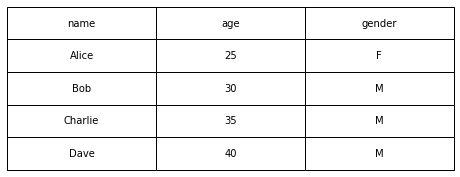

In [6]:
import pandas as pd
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt

# 創建一個 DataFrame
df = pd.DataFrame({'name': ['Alice', 'Bob', 'Charlie', 'Dave'],
                   'age': [25, 30, 35, 40],
                   'gender': ['F', 'M', 'M', 'M']})

# 將 DataFrame 轉換為圖片
fig, ax =plt.subplots(figsize=(8,3))
ax.axis('off')
ax.table(cellText=df.values, colLabels=df.columns, loc='center', cellLoc='center', bbox=[0, 0, 1, 1])
plt.show()
# buffer = BytesIO()
fig.savefig('my_table.png')
# buffer.seek(0)
# img = Image.open(buffer)

# # 顯示圖片
# img.show()

# # 儲存圖片
# img.save('my_table.png')
